# Enumerating BiCliques to Find Frequent Patterns

#### KDD 2019 Workshop

#### Authors
- Tom Drabas (Microsoft)
- Brad Rees (NVIDIA)
- Juan-Arturo Herrera-Ortiz (Microsoft)

#### Problem overview
From time to time PCs running Microsoft Windows fail: a program might crash or hang, or you experience a kernel crash leading to the famous blue screen (we do love those 'Something went wrong' messages as well...;)).

<img src="images/Windows_SomethingWentWrong.png" alt="Windows problems" width=380px class="center"/>

Well, when this happens it's not a good experience and we are truly interested in quickly finding out what might have gone wrong and/or at least what is common among the PCs that have failed.

## Import necessary modules

In [1]:
import cudf
import numpy
import azureml.core as aml
import time

## Load the data

The data prepared for this workshop will be available to download after the conference. We will share the link in the final notebook that will be available on RAPIDS github account. 

### Data
The data we will be using in this workshop has been synthetically generate to showcase the type of scenarios we encounter in our work. 

While running certain workloads, PCs might fail for one reason or another. We collect the information from both types of scenarios and enrich the observations with the metadata about each PC (hardware, software, failure logs etc.). This forms a dataset where each row represents a PC and the features column contains a list of all the metadata we want to mine to find frequent patterns about the population that has failed. 

In this tutorial we will be representing this data in a form of a bi-partite graph. A bi-partite graph can be divided into two disconnected subgraphs (none of the vertices within the subgraphs are connected) with the edges connecting the vertices from one subgraph to the other. See the example below.

<img src="images/BiPartiteGraph_Example.png" alt="Bi-Partite graph example" width=200px class="center"/>

In order to operate on this type of data we convert the list-of-features per row to a COO (Coordinate list) format: each row represents an edge connection, the first column contains the source vertex, the second one contains the destination vertex, and the third column contains the failure flag (0 = success, 1 = failure).

In [2]:
!head -n 3 ../../../../data/fpm_graph/coo_fpm.csv

0,1011392,0
0,1014082,0
0,1010117,0


Now we can load the data into a RAPIDS DataFrame `cudf`. ***NOTE: This will take longer than if you were running this on your local machine since the data-store is separate from this running VM. Normally it would be almost instant.***

In [3]:
%%time
fpm_df = cudf.read_csv('../../../../data/fpm_graph/coo_fpm.csv', names=['src', 'dst', 'flag'])

CPU times: user 980 ms, sys: 794 ms, total: 1.77 s
Wall time: 1.83 s


In [5]:
import pandas as pd

In [6]:
%%time
fpm_pdf = pd.read_csv('../../../../data/fpm_graph/coo_fpm.csv', names=['src', 'dst', 'flag'])

CPU times: user 8.72 s, sys: 1.02 s, total: 9.75 s
Wall time: 9.77 s


Now that we have the data loaded let's check how big is our data.

In [7]:
%%time
shp = fpm_df.shape
print('Row cnt: {0}, col cnt: {1}'.format(*shp))

Row cnt: 41068808, col cnt: 3
CPU times: user 499 µs, sys: 107 µs, total: 606 µs
Wall time: 441 µs


So, we have >41M records in our DataFrame. Let's see what it looks like:

In [8]:
print(fpm_df.head(10))

    src      dst  flag
0    0  1011392     0
1    0  1014082     0
2    0  1010117     0
3    0  1010886     0
4    0  1000005     0
5    0  1005000     0
6    0  1010251     0
7    0  1003084     0
8    0  1006540     0
9    0  1012174     0


## Understand the data

Now that we have the data, let's explore it a bit.

### Overall failure rate
First, let's find out what is the overall failure rate. In general, we do not want to extract any patterns that are below the overall failure rate since the would not help us to understand anything about the phenomenon we're dealing with nor would help us pinpoint the actual problems.

In [9]:
%%time
print(fpm_df['flag'].sum() / float(fpm_df['flag'].count()))

0.16653843471668328
CPU times: user 0 ns, sys: 3.23 ms, total: 3.23 ms
Wall time: 2.34 ms


So, the overall falure rate is 16.7%. However, you can see that running a `sum` and `count` reducers on 41M records took ~5-10ms.

### Device count

I didn't tell you how many devices we included in the dataset. Let's figure it out. Since the `src` column contains multiple edges per PC we need to count only the unique ids for this column.

In [10]:
%%time
print(fpm_df['src'].unique().count())

755775
CPU times: user 518 ms, sys: 70 ms, total: 588 ms
Wall time: 603 ms


So, we have 755k devices in the dataset and it took only 1s to find this out!!!

### Distinct features count
Let's now check how many distinct meatadata features we included in the dataset

In [11]:
%%time
print(fpm_df['dst'].unique().count())

15000
CPU times: user 221 ms, sys: 119 ms, total: 340 ms
Wall time: 348 ms


Now you can see it is a synthetic dataset ;) We have a universe of 15k distinct metadata features each PC can be comprised of.

### Degree distribution

Different PCs have different number of features: some have two CPUs or 4 GPUs (lucky...). Below we can quickly find how many features each PCs has.

In [12]:
%%time
degrees = fpm_df.groupby('src').agg({'dst': 'count'})
print(degrees)

    dst
src
0   70
1   60
2   74
3   69
4   77
5   62
6   62
7   67
8   53
9   66
[755765 more rows]
CPU times: user 100 ms, sys: 39.1 ms, total: 139 ms
Wall time: 157 ms


In [13]:
print(
    'On average PCs have {0:.2f} components. The one with the max numer has {1}.'
    .format(
          degrees['dst'].mean()
        , degrees['dst'].max()
    )
)

On average PCs have 54.34 components. The one with the max numer has 100.


### Inspecting the distribution of degrees

We can very quickly calculate the deciles of degrees.

In [14]:
%%time
quantiles = degrees.quantile(q=[float(e) / 100 for e in range(0, 100, 10)])
print(quantiles.to_pandas())

   Quantile   dst
0       0.0  22.0
1       0.1  38.0
2       0.2  41.0
3       0.3  44.0
4       0.4  51.0
5       0.5  56.0
6       0.6  59.0
7       0.7  62.0
8       0.8  65.0
9       0.9  70.0
CPU times: user 91.4 ms, sys: 19.9 ms, total: 111 ms
Wall time: 122 ms


Let's see how the distribution looks like.

In [15]:
%%time
buckets = degrees['dst'].value_counts().reset_index().to_pandas()
buckets.columns = ['Bucket', 'Count']

CPU times: user 229 ms, sys: 4.29 ms, total: 233 ms
Wall time: 235 ms


<BarContainer object of 74 artists>

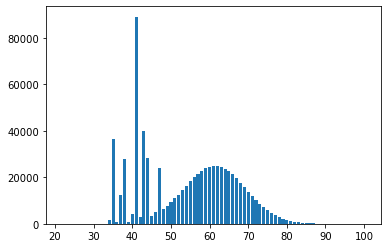

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(buckets['Bucket'], buckets['Count'])

## Mine the data and find the bi-cliques

In this part of the tutorial we will show you the prototype implementation of the iMBEA algorithm proposed in Zhang, Y et al. paper from 2014 titled _On finding bicliques in bipartite graphs: A novel algorithm and its application to the integration of diverse biological data types_ published in BMC bioinformatics 15 (110) URL: https://www.researchgate.net/profile/Michael_Langston/publication/261732723_On_finding_bicliques_in_bipartite_graphs_A_novel_algorithm_and_its_application_to_the_integration_of_diverse_biological_data_types/links/00b7d53a300726c5b3000000/On-finding-bicliques-in-bipartite-graphs-A-novel-algorithm-and-its-application-to-the-integration-of-diverse-biological-data-types.pdf

### Setup
First, we do some setting up.

In [17]:
from collections import OrderedDict
import numpy as np

# must be factor of 10
PART_SIZE  = int(1000)

### Data partitioning
We partition the DataFrame into multiple parts to aid computations.

In [18]:
def _partition_data_by_feature(_df) :
    
    #compute the number of sets
    m = int(( _df['dst'].max() / PART_SIZE) + 1 )
    
    _ui = [None] * (m + 1)
        
    # Partition the data into a number of smaller DataFrame
    s = 0
    e = s + PART_SIZE

    for i in range (m) :    
        _ui[i] = _df.query('dst >= @s and dst < @e')

        s = e
        e = e + PART_SIZE   
        
    return _ui, m

### Enumerating features
One of the key components of iMBEA algorithm is how it scans the graph starting from, in our case, from the most popular to the least popular feature. The `_count_features(...)` method below achieves exactly that and produces a sorted list of features ranked by their popularity.

In [19]:
def _count_features( _gdf, sort=True) :

    aggs = OrderedDict()
    aggs['dst'] = 'count'

    c = fpm_df.groupby(['dst'], as_index=False).agg(aggs) 
    c = c.rename(columns={'dst':'count'})   
    c = c.reset_index()

    if (sort) :
        c = c.sort_values(by='count', ascending=False)

    return c

In [20]:
print(_count_features(fpm_df))

        dst  count
1569  1001569  72525
3045  1003045  72525
7139  1007139  72525
7665  1007665  72525
9126  1009126  72525
10095  1010095  72525
12514  1012514  72525
14378  1014378  72525
2  1000002  62204
1510  1001510  62204
[14990 more rows]


### Fundamental methods

Below are some fundamental methods used iteratively by the final algorithm

#### `get_src_from_dst`
This method returns a DataFrame of all the source vertices that have the destination vertex `id` in their list of features.

In [21]:
# get all src vertices for a given dst
def get_src_from_dst( _gdf, id) :
    
    _src_list = (_gdf.query('dst == @id'))
    
    _src_list.drop_column('dst')
    
    return _src_list

#### `get_all_features`
This method returns all the features that are connected to the vertices found in the `src_list_df`.

In [22]:
# get all the items used by the specified users
def get_all_feature(_gdf, src_list_df, N) :
    
    c = [None] * N
    
    for i in range(N) :
        c[i] = src_list_df.merge(_gdf[i], on='src', how="inner")    
  
    return cudf.concat(c)

#### `is_same_as_last`
This method checks if the bi-clicque has already been enumerated.

In [23]:
def is_same_as_last(_old, _new) :
    status = False
    
    if (len(_old) == len(_new)) :
        m = _old.merge(_new, on='src', how="left")  
        
        if m['src'].null_count == 0 :
            status = True
    
    return status

#### `update_results`
This is a util method that helps to (1) maintain a DataFrame with enumerated bi-cliques that contains some of the `src` and `dst` vertices, and (2) some basic information about these.

In [24]:
def update_results(m, f, key, b, s) :
    """
    Input
    * m = machines
    * f = features
    * key = cluster ID
    * b = biclique answer
    * s = stats answer 

    Returns
    -------     
    B : cudf.DataFrame      
        A dataframe containing the list of machine and features.  This is not the full
        edge list to save space.  Since it is a biclique, it is easy to recreate the edges  
      
        B['id']    - a cluster ID (this is a one up number - up to k)
        B['vert']  - the vertex ID
        B['type']  - 0 == machine, 1 == feature
      
    
    S : cudf.DataFrame
        A Pandas dataframe of statistics on the returned info.  
        This dataframe is (relatively small) of size k.  
        
        S['id']       - the cluster ID
        S['total']    - total vertex count
        S['machines'] - number of machine nodes
        S['features'] - number of feature vertices
        S['bad_ratio'] - the ratio of bad machine / total machines
    """
    
    B = cudf.DataFrame()
    S = cudf.DataFrame()

    m_df = cudf.DataFrame()
    m_df['vert'] = m['src'].astype(np.int32)
    m_df['id']   = int(key)
    m_df['type'] = int(0) 
    
    
    f_df = cudf.DataFrame()
    f_df['vert'] = f['dst'].astype(np.int32)
    f_df['id']   = int(key)
    f_df['type'] = int(1)
    
    if len(b) == 0 :
        B = cudf.concat([m_df, f_df])
    else :
        B = cudf.concat([b, m_df, f_df])
    
    # now update the stats
    num_m = len(m_df)
    num_f = len(f_df)
    total = num_m# + num_f
    
    num_bad = len(m.query('flag == 1'))
    ratio = num_bad / total

    # now stats
    s_tmp = cudf.DataFrame()
    s_tmp['id']   = key
    s_tmp['total'] = total 
    s_tmp['machines'] = num_m
    s_tmp['bad_machines'] = num_bad
    s_tmp['features'] = num_f
    s_tmp['bad_ratio'] = ratio    
    
    if len(s) == 0 :
        S = s_tmp
    else :
         S = cudf.concat([s,s_tmp])
    
    del m_df
    del f_df
    
    return B, S

#### `ms_find_maximal_bicliques`
This is the main loop for the algorithm. It iteratively scans the list of features and enumerates the bi-cliques. 

In [25]:
def ms_find_maximal_bicliques(df, k, 
                              offset=0, 
                              max_iter=-1, 
                              support=1.0, 
                              min_features=1, 
                              min_machines=10) :
    """
    Find the top k maximal bicliques
 
    Parameters
    ---------- 
    df :  cudf:DataFrame
        A dataframe containing the bipartite graph edge list
        Columns must be called 'src', 'dst', and 'flag'
        
    k  :  int
        The max number of bicliques to return
        -1 mean all
    
    offset : int
      
    
    
    
    
    Returns
    -------     
    B : cudf.DataFrame      
        A dataframe containing the list of machine and features.  This is not the full
        edge list to save space.  Since it is a biclique, it is ease to recreate the edges  
      
        B['id']    - a cluster ID (this is a one up number - up to k)
        B['vert']  - the vertex ID
        B['type']  - 0 == machine, 1 == feature
      
    
    S : cudf.DataFrame 
        A dataframe of statistics on the returned info.  
        This dataframe is (relatively small) of size k.  
        
        S['id']       - the cluster ID
        S['total']    - total vertex count
        S['machines'] - number of machine nodes
        S['features'] - number of feature vertices
        S['bad_ration'] - the ratio of bad machine / total machines
    
    
    """
    
    
    x = [col for col in df.columns]
    if 'src' not in x:
       raise NameError('src column not found')
    if 'dst' not in x:
       raise NameError('dst column not found')   
    if 'flag' not in x:
       raise NameError('flag column not found')     

    if support > 1.0 or support < 0.1:
       raise NameError('support must be between 0.1 and 1.0')  
    
    
    # this removes a prep step that offset the values for CUDA process
    if offset > 0 :
        df['dst'] = df['dst'] - offset    

    # break the data into chunks to improve join/search performance 
    src_by_dst, num_parts = _partition_data_by_feature(df)    

    # Get a list of all the dst (features) sorted by degree 
    f_list = _count_features(df, True)     

    # create a dataframe for the answers
    bicliques = cudf.DataFrame()
    stats     = cudf.DataFrame()

    # create a dataframe to help prevent duplication of work
    machine_old = cudf.DataFrame()   
    
    # create a dataframe for stats
    stats = cudf.DataFrame()
    
    answer_id = 0
    iter_max = len(f_list)
    
    if max_iter != -1 :
        iter_max = max_iter
    
    # Loop over all the features (dst) or until K is reached
    for i in range(iter_max) :

        # pop the next feature to process
        feature = f_list['dst'][i]
        degree  = f_list['count'][i]
        
        # compute the index to this item (which dataframe chunk is in)
        idx = int(feature/PART_SIZE)        
        
        # get all machines that have this feature
        machines = get_src_from_dst(src_by_dst[idx], feature) 

        # if this set of machines is the same as the last, skip this feature
        if is_same_as_last(machine_old, machines) == False:

            # now from those machines, hop out to the list of all the features 
            feature_list = get_all_feature(src_by_dst, machines, num_parts)   

            # summarize occurrences
            ic = _count_features(feature_list, True)

            goal = int(degree * support)
            
            # only get dst nodes with the same degree
            c = ic.query('count >= @goal')

            # need more than X feature to make a biclique
            if len(c) > min_features : 
                if len(machines) >= min_machines :
                    bicliques, stats = update_results(machines, c, answer_id, bicliques, stats)

                    answer_id = answer_id + 1
            
        # end - if same
    
        machine_old = machines
    
        if k > -1:
            if answer_id == k :
                break
            
    # end for loop

    # All done, reset data
    if offset > 0 :
        df['dst'] = df['dst'] + offset  
        
    return bicliques, stats

### Finding bi-cliques
Now that we have a fundamental understanding how this works -- let's put it to action.

In [26]:
%%time
bicliques, stats = ms_find_maximal_bicliques(
    df=fpm_df, 
    k=10, 
    offset=1000000, 
    max_iter=100,
    support = 1.0,
    min_features=3,
    min_machines=100
)

CPU times: user 6 s, sys: 2.28 s, total: 8.28 s
Wall time: 8.75 s


It takes somewhere between <font size="10">10 to 15 seconds</font> to analyze <font size="10">>42M</font>edges and output the top 10 most important bicliques.

Let's see what we got. We enumerated 10 bicliques. The worst of them had a failure rate of over 97%.

In [27]:
print(stats)

    id  total  machines  bad_machines  features            bad_ratio
0   0  72525     72525         52876         8   0.7290727335401586
0   1  62204     62204         57025        19   0.9167416886373867
0   2  43854     43854         42673        22    0.973069731381402
0   3  41268     41268         17844        36  0.43239313753998254
0   4  37745     37745          3085        41   0.0817326798251424
0   5  30751     30751         12868        54   0.4184579363272739
0   6  14713     14713         14298        57   0.9717936518724937
0   7  14369     14369         13970        59   0.9722318880924212
0   8  11282     11282         10009        66   0.8871653962063464
0   9   6289      6289          6133        70   0.9751947845444426


Let's look at the one of the worst ones that affected the most machines: over 57k.

In [28]:
bicliques.query('id == 1 and type == 1')['vert'].sort_values().to_pandas()

2            2
1510      1510
1569      1569
1604      1604
2964      2964
3045      3045
3581      3581
5390      5390
7139      7139
7665      7665
7686      7686
8226      8226
9087      9087
9126      9126
10095    10095
12514    12514
14376    14376
14378    14378
14579    14579
Name: vert, dtype: int32

If you change the `type` to `0` we could retrieve a sample list of PCs that fit this particular pattern/bi-clique: this is useful and sometimes helps us to further narrow down a problem by further scanning the logs from PCs.